In [5]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [6]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3 5778k    3  220k    0     0   115k      0  0:00:50  0:00:01  0:00:49  115k
 33 5778k   33 1940k    0     0   693k      0  0:00:08  0:00:02  0:00:06  693k
100 5778k  100 5778k    0     0  1652k      0  0:00:03  0:00:03 --:--:-- 1652k
"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
‘ЁбвҐ¬Ґ ­Ґ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© Їгвм.


In [77]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 4808k    0 11401    0     0  32855      0  0:02:29 --:--:--  0:02:29 32761
 14 4808k   14  699k    0     0   512k      0  0:00:09  0:00:01  0:00:08  511k
 22 4808k   22 1104k    0     0   451k      0  0:00:10  0:00:02  0:00:08  451k
 59 4808k   59 2864k    0     0   867k      0  0:00:05  0:00:03  0:00:02  867k
100 4808k  100 4808k    0     0  1157k      0  0:00:04  0:00:04 --:--:-- 1157k


In [10]:
import zipfile
with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
# !cd ml-1m/

In [78]:
import zipfile
with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
    
# !cd ml-1m/

In [4]:
seed = 47
np.random.seed(seed)

We will use the following blogpost's independent code to benchmark our experiments https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

# Independent MF code

In [23]:
names = ['user_id', 'item_id', 'rating']
df = pd.read_csv('./ml-1m/ratings.dat', sep='::', usecols = [0, 1, 2], names=names)
df.head()

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [25]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_users, n_items

(6040, 3706)

In [32]:
df.item_id.unique().max(), df.item_id.unique().shape, df.item_id.unique().max()

(3952, (3706,), 3952)

In [34]:
n_users = df.user_id.unique().max()
n_items = df.item_id.unique().max()
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
#     print(row)
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [36]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [37]:
get_sparsity(ratings)

4.190220560634904

In [64]:
def train_test_split(ratings):
    np.random.seed(seed)
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [73]:
train_1m, test_1m = train_test_split(ratings)

In [74]:
train_1m

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

In [75]:
test_1m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
get_sparsity(train_1m), get_sparsity(test_1m)

(3.93718412338794, 0.25303643724696356)

In [81]:
# movielens-100k dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [82]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [83]:
train_100k, test_100k = train_test_split(ratings)

In [84]:
get_sparsity(train_100k), get_sparsity(test_100k)

(5.710139043178159, 0.5945303210463734)

In [137]:
train_100k.shape, train_1m.shape

((943, 1682), (6040, 3952))

In [241]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        np.random.seed(seed)
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        np.random.seed(seed)
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        np.random.seed(seed)
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        np.random.seed(seed)
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        np.random.seed(seed)
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [98]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [102]:
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 8.162626454488155
Test mse: 11.074297483666612
Iteration: 2
Train mse: 5.710628199541684
Test mse: 8.654294898028265
Iteration: 5
Train mse: 5.421378301611028
Test mse: 8.237957326989877
Iteration: 10
Train mse: 5.3966006950612435
Test mse: 8.199281754444268
Iteration: 25
	current iteration: 10
Train mse: 5.3948135876025365
Test mse: 8.195283711199771
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394753065812939
Test mse: 8.195083034461906
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.394526731799798
Test mse: 8.194863821632225


In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

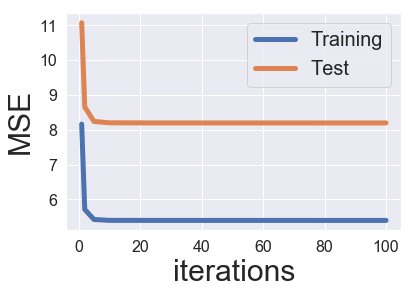

In [104]:
plot_learning_curve(iter_array, MF_ALS)

In [105]:
MF_ALS = ExplicitMF(train_1m, n_factors=20, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_1m)

Iteration: 1
Train mse: 8.133017313467287
Test mse: 11.385478952329686
Iteration: 2
Train mse: 6.181422331570321
Test mse: 9.510432053967698
Iteration: 5
Train mse: 5.945868319505223
Test mse: 9.181499199125527
Iteration: 10
Train mse: 5.929921005207816
Test mse: 9.163591900058499
Iteration: 25
	current iteration: 10
Train mse: 5.922879579194776
Test mse: 9.155637570112932
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.921741164281515
Test mse: 9.152673442345948
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.921434636456923
Test mse: 9.152593151189302


In [110]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142807793060997
Test mse: 1.1796269767247503
Iteration: 2
Train mse: 1.0730325987217215
Test mse: 1.1283621352778417
Iteration: 5
Train mse: 0.9767157588922124
Test mse: 1.0499014864558258
Iteration: 10
Train mse: 0.9190727366615857
Test mse: 0.9988387536431501
Iteration: 25
	current iteration: 10
Train mse: 0.8669457204379917
Test mse: 0.9525818812444498
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8387251669562131
Test mse: 0.9343161812537658
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7485848531412769
Test mse: 0.9170005429005551
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40410579696377263
Test mse: 0.9148070379768369


# Our Proposed GAN

In [111]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

In [113]:
zero_mask = (train_100k == 0)
positive_feedback = (train_100k > 3)
negative_feedback = ((train_100k < 4) * (1 - zero_mask))

In [114]:
positive_feedback.sum(), negative_feedback.sum()

(49901, 40669)

In [115]:
assert (positive_feedback + negative_feedback != zero_mask).all()
assert (positive_feedback + negative_feedback == 1 - zero_mask).all()

In [116]:
get_sparsity(zero_mask), get_sparsity(positive_feedback), get_sparsity(negative_feedback)

(94.28986095682184, 3.146093059441684, 2.5640459837364746)

In [335]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, mat, p=0.4, batch_size=64):
        '''
        mat is a binary matrix (e.g. positive feedback, or negative feedback)
        '''
        self.batch_size = batch_size
        self.mat = mat
        self.p = p

    def __len__(self):
        return int(np.floor(self.mat.shape[0] / self.batch_size))
    
    def gen_item_GAN(self):
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y, indexes
        
    def __getitem__(self, index):
        
        indexes = np.random.randint(self.mat.shape[0], size=self.batch_size)

        mask = (np.random.rand(self.batch_size, self.mat.shape[1]) > self.p)
        
        y = self.mat[indexes]
        X = self.mat[indexes]*mask # corrupting
        
        return X, y

In [336]:
generator_negative = DataGenerator(negative_feedback)

In [337]:
x, y, _ = generator_negative.gen_item_GAN()

In [338]:
x.shape, y.shape

((64, 1682), (64, 1682))

In [339]:

class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 512)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 512)
        # combined
        self.fc = torch.nn.Linear(2 * 512, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 512), 
#                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
# #                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(2048, 2048),
                                torch.nn.ReLU(), 
#                                 torch.nn.BatchNorm1d(512),
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(512, self.feat_size), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
#         print(x.shape, )
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [340]:
gen_losses = []
disc_losses = []
def train_GAN(netD, netG, negative, tr, steps_per_epoch = 200, epochs = 10):
    d_iter = 5
    g_iter = 1
    gen_iterations = 0
#     gen_losses = []
#     disc_losses = []
#     train_losses = []
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            data_iter = 100
            i = 0
#             while i < 100:
            ############################
            # (1) Update D network
            ###########################
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
#             d_iter = d_iter
            j = 0
            while j < d_iter*5:
                j += 1
                # load real data
                i += 1
                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()
#                         condition, X, idxs = batch_generator(X_neg, y_neg)
#                 X, _ = data_iter.next()
#                 X = X.view(X.size(0), -1)
#                 X = (X >= 0.5).float()
#                     if cuda: 
                X = torch.from_numpy(X).float().cuda()
#                     X = X + torch.randn(X.size()).cuda() * 0.2
                condition = torch.from_numpy(condition).float().cuda() 
#     + torch.randn(X.size()).cuda() * 0.2
#                 print(condition.shape, X_neg.shape, y_neg.shape)
                real = Variable(X)

                # generate fake data
                noise = torch.randn(batch_size, nz)
#                     if cuda: 
                noise = noise.cuda()
#                     noisev = Variable(noise, volatile = True) # totally freeze netG
                with torch.no_grad():
                    noisev = Variable(noise) # totally freeze netG
                concated = torch.cat((noisev, condition), 1)
#                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
                e_mask = torch.Tensor(tr[idxs]>0).cuda()
#                     print(e_mask.shape, concated.shape, condition.shape)
                fake = Variable(netG(e_mask, concated).data)

                # compute gradient, take step
                netD.zero_grad()
#                 concated_real = torch.cat((real, condition), 1)
#                 print(concated_real)
                out = netD(real, fake)
                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()
#                     print('AAAAAAAAA mse:=WWWWWWWWWWWWWWWWWWWWWW')
        ############################
        # (2) Update G network
        ###########################

#         g_iter = g_iter
            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                # load real data

                i += 1

                if negative:
                    condition, X, idxs = generator_negative.gen_item_GAN()

                X = torch.from_numpy(X).float().cuda()
    #                 X = X + torch.randn(X.size()).cuda() * 0.2
                condition = torch.from_numpy(condition).float().cuda() 
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
                noise = noise.cuda()
                noisev = Variable(noise)
                concated_ = torch.cat((noisev, condition), 1)
                e_mask_ = torch.Tensor(tr[idxs]>0).cuda()

                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
    #             print('AAAAAA')
                eval_loss = F.mse_loss(fake, real, reduction='mean')
    #             eval_losses.append(eval_loss)
    #             print('mse:', eval_loss)
    #             print(outputG.item(), outputD.item())
                gen_losses.append(outputG.item())
                disc_losses.append(outputD.item())
                print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()), eval_loss)
    return gen_losses, disc_losses

In [341]:
lrD = 5e-4
lrG = 5e-4
batch_size = 64
cuda = True
epochs = 10
# device = 5
seed = 1
nz = 8
lamba = 1e-3

In [342]:
# networks
netD_neg = NetD(train_100k.shape[1]).cuda()
netG_neg = NetG(train_100k.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.RMSprop(netG_neg.parameters(), lr=lrG, weight_decay=1e-4)
optimizerD = optim.RMSprop(netD_neg.parameters(), lr=lrD, weight_decay=1e-4)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=1682, out_features=512, bias=True)
  (b1): Linear(in_features=1682, out_features=512, bias=True)
  (fc): Linear(in_features=1024, out_features=1682, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)


In [343]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
train_GAN(netD_neg, netG_neg, tr=train_100k, epochs=10, negative=True)

[0/10][26/100][1] Loss_D: 0.015396 Loss_G: 0.012399 
[0/10][26/100][2] Loss_D: 0.008699 Loss_G: 0.009984 
[0/10][26/100][3] Loss_D: 0.010232 Loss_G: 0.012696 
[0/10][26/100][4] Loss_D: 0.007697 Loss_G: 0.004789 
[0/10][26/100][5] Loss_D: 0.002852 Loss_G: 0.003720 
[0/10][26/100][6] Loss_D: 0.001300 Loss_G: 0.001948 
[0/10][26/100][7] Loss_D: 0.003648 Loss_G: 0.002399 
[0/10][26/100][8] Loss_D: 0.001874 Loss_G: 0.003110 
[0/10][26/100][9] Loss_D: 0.001165 Loss_G: 0.001428 
[0/10][26/100][10] Loss_D: 0.001839 Loss_G: 0.002717 
[0/10][26/100][11] Loss_D: 0.002029 Loss_G: 0.001121 
[0/10][26/100][12] Loss_D: 0.001037 Loss_G: -0.000022 
[0/10][26/100][13] Loss_D: 0.000467 Loss_G: 0.000503 
[0/10][26/100][14] Loss_D: 0.002084 Loss_G: 0.002133 
[0/10][26/100][15] Loss_D: 0.001187 Loss_G: 0.000905 
[0/10][26/100][16] Loss_D: 0.000913 Loss_G: 0.002143 
[0/10][26/100][17] Loss_D: 0.005114 Loss_G: 0.001427 
[0/10][26/100][18] Loss_D: 0.003440 Loss_G: 0.002312 
[0/10][26/100][19] Loss_D: 0.001970 

[0/10][26/100][152] Loss_D: 0.005536 Loss_G: 0.003550 
[0/10][26/100][153] Loss_D: 0.002474 Loss_G: 0.001116 
[0/10][26/100][154] Loss_D: 0.004742 Loss_G: 0.003278 
[0/10][26/100][155] Loss_D: 0.003442 Loss_G: 0.004659 
[0/10][26/100][156] Loss_D: 0.003816 Loss_G: 0.002365 
[0/10][26/100][157] Loss_D: 0.002468 Loss_G: 0.001261 
[0/10][26/100][158] Loss_D: 0.002932 Loss_G: 0.004094 
[0/10][26/100][159] Loss_D: 0.002777 Loss_G: 0.002601 
[0/10][26/100][160] Loss_D: 0.000639 Loss_G: 0.003937 
[0/10][26/100][161] Loss_D: 0.003193 Loss_G: 0.004437 
[0/10][26/100][162] Loss_D: 0.003551 Loss_G: 0.002200 
[0/10][26/100][163] Loss_D: 0.003474 Loss_G: 0.003950 
[0/10][26/100][164] Loss_D: 0.004544 Loss_G: 0.003059 
[0/10][26/100][165] Loss_D: 0.001576 Loss_G: 0.003488 
[0/10][26/100][166] Loss_D: 0.003523 Loss_G: 0.003235 
[0/10][26/100][167] Loss_D: 0.002024 Loss_G: 0.002194 
[0/10][26/100][168] Loss_D: 0.001142 Loss_G: 0.005256 
[0/10][26/100][169] Loss_D: 0.005600 Loss_G: 0.002734 
[0/10][26/

[1/10][26/100][301] Loss_D: 0.000032 Loss_G: 0.002480 
[1/10][26/100][302] Loss_D: 0.004537 Loss_G: 0.005117 
[1/10][26/100][303] Loss_D: 0.005361 Loss_G: 0.004975 
[1/10][26/100][304] Loss_D: 0.002620 Loss_G: 0.003241 
[1/10][26/100][305] Loss_D: 0.003712 Loss_G: 0.002655 
[1/10][26/100][306] Loss_D: 0.002219 Loss_G: 0.002315 
[1/10][26/100][307] Loss_D: 0.003433 Loss_G: 0.004483 
[1/10][26/100][308] Loss_D: 0.003679 Loss_G: 0.003354 
[1/10][26/100][309] Loss_D: 0.003732 Loss_G: 0.001947 
[1/10][26/100][310] Loss_D: 0.001998 Loss_G: 0.003749 
[1/10][26/100][311] Loss_D: 0.002352 Loss_G: 0.001317 
[1/10][26/100][312] Loss_D: 0.001862 Loss_G: 0.001697 
[1/10][26/100][313] Loss_D: 0.002955 Loss_G: 0.004951 
[1/10][26/100][314] Loss_D: 0.002624 Loss_G: 0.002238 
[1/10][26/100][315] Loss_D: 0.003031 Loss_G: 0.003324 
[1/10][26/100][316] Loss_D: 0.002723 Loss_G: 0.002015 
[1/10][26/100][317] Loss_D: 0.004062 Loss_G: 0.001314 
[1/10][26/100][318] Loss_D: 0.002411 Loss_G: 0.003139 
[1/10][26/

[2/10][26/100][450] Loss_D: 0.003610 Loss_G: 0.003299 
[2/10][26/100][451] Loss_D: 0.003675 Loss_G: 0.004763 
[2/10][26/100][452] Loss_D: 0.002241 Loss_G: 0.002938 
[2/10][26/100][453] Loss_D: 0.002835 Loss_G: 0.004185 
[2/10][26/100][454] Loss_D: 0.002765 Loss_G: 0.003533 
[2/10][26/100][455] Loss_D: 0.003136 Loss_G: 0.001948 
[2/10][26/100][456] Loss_D: 0.002970 Loss_G: 0.002815 
[2/10][26/100][457] Loss_D: 0.002586 Loss_G: 0.001813 
[2/10][26/100][458] Loss_D: 0.002609 Loss_G: 0.001417 
[2/10][26/100][459] Loss_D: 0.003130 Loss_G: 0.001706 
[2/10][26/100][460] Loss_D: 0.001854 Loss_G: 0.002468 
[2/10][26/100][461] Loss_D: 0.002961 Loss_G: 0.002250 
[2/10][26/100][462] Loss_D: 0.002596 Loss_G: 0.002183 
[2/10][26/100][463] Loss_D: 0.002624 Loss_G: 0.002826 
[2/10][26/100][464] Loss_D: 0.004170 Loss_G: 0.001324 
[2/10][26/100][465] Loss_D: 0.003162 Loss_G: 0.005163 
[2/10][26/100][466] Loss_D: 0.002802 Loss_G: 0.002031 
[2/10][26/100][467] Loss_D: 0.003196 Loss_G: 0.002637 
[2/10][26/

[2/10][26/100][599] Loss_D: 0.002520 Loss_G: 0.002468 
[2/10][26/100][600] Loss_D: 0.002893 Loss_G: 0.003116 
[3/10][26/100][601] Loss_D: 0.004093 Loss_G: 0.002176 
[3/10][26/100][602] Loss_D: 0.003137 Loss_G: 0.003312 
[3/10][26/100][603] Loss_D: 0.001907 Loss_G: 0.002240 
[3/10][26/100][604] Loss_D: 0.002749 Loss_G: 0.003203 
[3/10][26/100][605] Loss_D: 0.001670 Loss_G: 0.002336 
[3/10][26/100][606] Loss_D: 0.004191 Loss_G: 0.002150 
[3/10][26/100][607] Loss_D: 0.001085 Loss_G: 0.002404 
[3/10][26/100][608] Loss_D: 0.004360 Loss_G: 0.001429 
[3/10][26/100][609] Loss_D: 0.004606 Loss_G: 0.002639 
[3/10][26/100][610] Loss_D: 0.003993 Loss_G: 0.002979 
[3/10][26/100][611] Loss_D: 0.004061 Loss_G: 0.003927 
[3/10][26/100][612] Loss_D: 0.003508 Loss_G: 0.003653 
[3/10][26/100][613] Loss_D: 0.001862 Loss_G: 0.002002 
[3/10][26/100][614] Loss_D: 0.002656 Loss_G: 0.002832 
[3/10][26/100][615] Loss_D: 0.004895 Loss_G: 0.002247 
[3/10][26/100][616] Loss_D: 0.001557 Loss_G: 0.003036 
[3/10][26/

[3/10][26/100][748] Loss_D: 0.003058 Loss_G: 0.002309 
[3/10][26/100][749] Loss_D: 0.002478 Loss_G: 0.001631 
[3/10][26/100][750] Loss_D: 0.001417 Loss_G: 0.002758 
[3/10][26/100][751] Loss_D: 0.002072 Loss_G: 0.002199 
[3/10][26/100][752] Loss_D: 0.003244 Loss_G: 0.002624 
[3/10][26/100][753] Loss_D: 0.000266 Loss_G: 0.001867 
[3/10][26/100][754] Loss_D: 0.001712 Loss_G: 0.002381 
[3/10][26/100][755] Loss_D: 0.001605 Loss_G: 0.002337 
[3/10][26/100][756] Loss_D: 0.002321 Loss_G: 0.002074 
[3/10][26/100][757] Loss_D: 0.002712 Loss_G: 0.001444 
[3/10][26/100][758] Loss_D: 0.002429 Loss_G: 0.003667 
[3/10][26/100][759] Loss_D: 0.003245 Loss_G: 0.002943 
[3/10][26/100][760] Loss_D: 0.003304 Loss_G: 0.003131 
[3/10][26/100][761] Loss_D: 0.003407 Loss_G: 0.002025 
[3/10][26/100][762] Loss_D: 0.002675 Loss_G: 0.001929 
[3/10][26/100][763] Loss_D: 0.003932 Loss_G: 0.001972 
[3/10][26/100][764] Loss_D: 0.002406 Loss_G: 0.003742 
[3/10][26/100][765] Loss_D: 0.003148 Loss_G: 0.002423 
[3/10][26/

KeyboardInterrupt: 

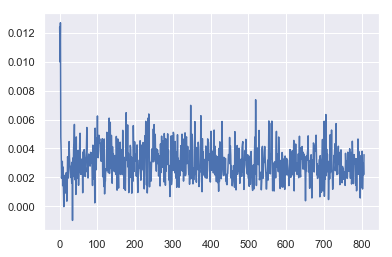

In [344]:
plt.plot(gen_losses)
plt.show()

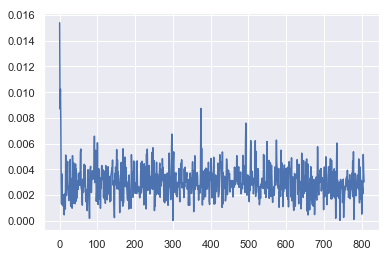

In [345]:
plt.plot(disc_losses)
plt.show()

In [346]:
# to test without train
netD_neg_test = NetD(train_100k.shape[1]).cuda()
netG_neg_test = NetG(train_100k.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [347]:
netD_neg.eval()
netG_neg.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=1690, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1682, bias=True)
    (3): Sigmoid()
  )
)

In [348]:
# checking accuraccy
condition = torch.from_numpy(negative_feedback).float().cuda() 
noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k > 0).cuda()

concated = torch.cat((noise, condition), 1)
fake_accur_check = netG_neg(e_mask, concated)

In [349]:
# without train
fake_test_accur_check = netG_neg_test(e_mask, concated)

In [350]:
fake_accur_check_ = (fake_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [351]:
fake_test_accur_check = (fake_test_accur_check.detach().cpu().numpy() > 0.5).astype(int)

In [352]:
(fake_accur_check_ * negative_feedback).sum(), (fake_accur_check_ * positive_feedback).sum()

(24943, 13093)

In [353]:
(fake_test_accur_check * negative_feedback).sum(), (fake_test_accur_check * positive_feedback).sum()

(20943, 26242)

In [354]:
# accuracy on negative items
(fake_accur_check_ * negative_feedback).sum() / negative_feedback.sum()

0.6133172686813052

In [355]:
# accuracy on negative items - WITHOUT TRAIN 
(fake_test_accur_check * negative_feedback).sum() / negative_feedback.sum()

0.5149622562639848

In [356]:
# accuracy on positive items
((1-fake_accur_check_) * positive_feedback).sum() / positive_feedback.sum()

0.7376204885673634

In [357]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.47411875513516766

In [358]:
# accuracy on positive items - WITHOUT TRAIN 
((1-fake_test_accur_check) * positive_feedback).sum() / positive_feedback.sum()

0.47411875513516766

In [359]:
import gc
gc.collect()

12430

In [361]:
torch.save(netD_neg.state_dict(), './netD_neg-100k')
torch.save(netG_neg.state_dict(), './netG_neg-100k')

In [362]:
del fake_accur_check
del fake_test_accur_check 
del e_mask

NameError: name 'fake_accur_check' is not defined

In [363]:
# condition, X, idxs = batch_generator(y_neg, to_add_negative, batch_size=256)
# predicting on ngetavie feedbacks
condition = torch.from_numpy(negative_feedback).float().cuda()
# X = torch.from_numpy(to_add_negative).cuda()


noise = torch.randn(condition.shape[0], nz).cuda()
# e_mask = torch.Tensor(to_add_negative).cuda()
e_mask = torch.Tensor(train_100k == 0).cuda()

concated = torch.cat((noise, condition), 1)
fake = netG_neg(e_mask, concated)

In [364]:
fake = (fake >0.9).cpu().numpy()

In [365]:
fake.sum()

394

In [366]:
to_augment_negative = fake

In [367]:
p_probs = [(train_100k == 1).sum()/((train_100k > 0) & (train_100k < 4)).sum(), (train_100k == 2).sum()/(((train_100k > 0) & (train_100k < 4))).sum(), (train_100k == 3).sum()/((train_100k > 0) & (train_100k < 4)).sum()]
p_probs

[0.13777078364356143, 0.2542968846049817, 0.6079323317514569]

In [368]:
augmented_train_100k = train_100k + to_augment_negative

In [369]:
get_sparsity(train_100k), get_sparsity(augmented_train_100k)

(5.710139043178159, 5.734979440473204)

In [248]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
MF_SGD.calculate_learning_curve([300], test_100k, learning_rate=0.001)

Iteration: 300
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
	current iteration: 210
	current iteration: 220
	current iteration: 230
	current iteration: 240
	current iteration: 250
	current iteration: 260
	current iteration: 270
	current iteration: 280
	current iteration: 290
	current iteration: 300
Train mse: 0.24780276795013206
Test mse: 0.9911321751624483


In [249]:
MF_SGD = ExplicitMF(augmented_train_100k, 40, learning='sgd', verbose=True)
MF_SGD.calculate_learning_curve([300], test_100k, learning_rate=0.001)

Iteration: 300
	current iteration: 10
	current iteration: 20


KeyboardInterrupt: 

In [247]:
MF_SGD = ExplicitMF(train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142822581632546
Test mse: 1.179626365384201
Iteration: 2
Train mse: 1.0730309645422471
Test mse: 1.1283647354414428
Iteration: 5
Train mse: 0.976704786728581
Test mse: 1.0498895036356708
Iteration: 10
Train mse: 0.9191190735106731
Test mse: 0.99882388507181
Iteration: 25
	current iteration: 10
Train mse: 0.8670975465312848
Test mse: 0.9525039875303193
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8395297477072872
Test mse: 0.9342662870213886
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7572607163519403
Test mse: 0.917558302954112
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40646564364302945
Test mse: 0.9047525011076776


In [246]:
MF_SGD = ExplicitMF(augmented_train_100k, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1583192976603522
Test mse: 1.1778921160446154
Iteration: 2
Train mse: 1.0827823219708648
Test mse: 1.124826924658217
Iteration: 5
Train mse: 0.9809962544391533
Test mse: 1.0456674228179015
Iteration: 10
Train mse: 0.9217915122656181
Test mse: 0.9960992361685521
Iteration: 25
	current iteration: 10
Train mse: 0.8695835693024129
Test mse: 0.9521000726072203
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8421152097706776
Test mse: 0.9345373660525688
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.755397379978269
Test mse: 0.916590796822304
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.40575111332308983
Test mse: 0.906762464167835


In [245]:
MF_ALS = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336


In [243]:
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314


In [250]:
# until test error starts to rise
MF_ALS = ExplicitMF(augmented_train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.35978032575701
Test mse: 8.193157746225948
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.359732338000212
Test mse: 8.193099816595986
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.359687859300

In [251]:
# until test error starts to rise
MF_ALS = ExplicitMF(train_100k, n_factors=10, learning='als',
                    user_fact_reg=0.1, item_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200]
MF_ALS.calculate_learning_curve(iter_array, test_100k)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.393714646752196
Test mse: 8.194362304310943
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.393666122560651
Test mse: 8.194304259396569
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.39362115513

In [253]:
# until test error starts to rise

best_sgd_model = ExplicitMF(train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1583192976603522
Test mse: 1.1778921160446154
Iteration: 2
Train mse: 1.0827823219708648
Test mse: 1.124826924658217
Iteration: 5
Train mse: 0.9809962544391533
Test mse: 1.0456674228179015
Iteration: 10
Train mse: 0.9217915122656181
Test mse: 0.9960992361685521
Iteration: 25
	current iteration: 10
Train mse: 0.8695835693024129
Test mse: 0.9521000726072203
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8421152097706776
Test mse: 0.9345373660525688
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.755397379978269
Test mse: 0.916590796822304
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.6846501387489577
Test mse: 0.9047955049119271
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.6088625770108296
Test mse: 0.8969742625646109
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse

In [372]:
# until convergence
best_sgd_model = ExplicitMF(augmented_train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.1545119024961061
Test mse: 1.178567399719999
Iteration: 2
Train mse: 1.0808310124661051
Test mse: 1.1261795339578151
Iteration: 5
Train mse: 0.9808797891168647
Test mse: 1.0474046524170364
Iteration: 10
Train mse: 0.9222637203091965
Test mse: 0.997286882756945
Iteration: 25
	current iteration: 10
Train mse: 0.8708585227221491
Test mse: 0.9523215310455245
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8464129951238863
Test mse: 0.9346230958725521
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7999830140159173
Test mse: 0.9226304802126559
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.7510374101643228
Test mse: 0.9117502158632841
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.6909018150472902
Test mse: 0.9010086763640088
Iteration: 160
	current iteration: 10
	current iteration: 20
Train ms

In [257]:
# until convergence
best_sgd_model = ExplicitMF(augmented_train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.158486007439644
Test mse: 1.1779978613000384
Iteration: 2
Train mse: 1.083171581612149
Test mse: 1.125028404345431
Iteration: 5
Train mse: 0.9817048627613273
Test mse: 1.0459868491969369
Iteration: 10
Train mse: 0.9227319825521801
Test mse: 0.9963652377560377
Iteration: 25
	current iteration: 10
Train mse: 0.8713373835757132
Test mse: 0.9521701303030687
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.846936197066563
Test mse: 0.934619043527751
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.8000609230973601
Test mse: 0.9225265969757358
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.7503523923902362
Test mse: 0.9115515826764651
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.689505366026202
Test mse: 0.9008884227444379
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 0

In [258]:
# until convergence
best_sgd_model = ExplicitMF(train_100k, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_sgd_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 1.142972933039822
Test mse: 1.17972828223402
Iteration: 2
Train mse: 1.0733920132206576
Test mse: 1.1285610630076768
Iteration: 5
Train mse: 0.9773881833559704
Test mse: 1.0502187304294268
Iteration: 10
Train mse: 0.9200456767969902
Test mse: 0.999134022874239
Iteration: 25
	current iteration: 10
Train mse: 0.8688346580213652
Test mse: 0.9526617108778075
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.8442347461991091
Test mse: 0.934442842680263
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.7999403795934972
Test mse: 0.9232297270102171
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 0.7525020754101615
Test mse: 0.9130561640976463
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 0.6925429566514093
Test mse: 0.902326297805037
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 0

In [259]:
best_als_model = ExplicitMF(train_100k, n_factors=10, learning='als', \
                            item_fact_reg=0.1, user_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_als_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 7.414043254856359
Test mse: 10.597071517103002
Iteration: 2
Train mse: 5.729849556962303
Test mse: 8.637501957776392
Iteration: 5
Train mse: 5.425216634306679
Test mse: 8.224449939246286
Iteration: 10
Train mse: 5.416034494374579
Test mse: 8.225911144030166
Iteration: 25
	current iteration: 10
Train mse: 5.405244808568524
Test mse: 8.212123871641975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.394015977369497
Test mse: 8.19475571062152
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.3937671853374605
Test mse: 8.19442505144314
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.393714646752196
Test mse: 8.194362304310943
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.393666122560651
Test mse: 8.194304259396569
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.39362115513

In [260]:
best_als_model = ExplicitMF(augmented_train_100k, n_factors=10, learning='als', \
                            item_fact_reg=0.1, user_fact_reg=0.1, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 120, 140, 160, 180, 200, 220]
best_als_model.calculate_learning_curve(iter_array, test_100k, learning_rate=0.001)

Iteration: 1
Train mse: 7.365331085064962
Test mse: 10.594736049344187
Iteration: 2
Train mse: 5.692327274625398
Test mse: 8.63601159502765
Iteration: 5
Train mse: 5.390926482500714
Test mse: 8.223490099578223
Iteration: 10
Train mse: 5.382053601809805
Test mse: 8.224694402460047
Iteration: 25
	current iteration: 10
Train mse: 5.365488278184999
Test mse: 8.201579412685142
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 5.3600334033203785
Test mse: 8.193471712808986
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 5.35983226130889
Test mse: 8.193220337124336
Iteration: 120
	current iteration: 10
	current iteration: 20
Train mse: 5.35978032575701
Test mse: 8.193157746225948
Iteration: 140
	current iteration: 10
	current iteration: 20
Train mse: 5.359732338000212
Test mse: 8.193099816595986
Iteration: 160
	current iteration: 10
	current iteration: 20
Train mse: 5.359687859300

In [330]:
from sklearn.decomposition import NMF
model = NMF(n_components=10, max_iter=400, alpha=0.1, init='nndsvdar', random_state=seed)
W = model.fit_transform(train_100k)
H = model.components_

In [331]:
W.shape, H.shape

((943, 10), (10, 1682))

In [332]:
get_mse(test_100k, np.matmul(W,H))

0.4260560791980288

In [333]:
# model = NMF(n_components=20, max_iter=800, init='nndsvdar', beta_loss='frobenius', alpha=0.1, random_state=seed)
model = NMF(n_components=10, max_iter=400, alpha=0.1, init='nndsvdar', random_state=seed)
W = model.fit_transform(augmented_train_100k)
H = model.components_

In [334]:
get_mse(test_100k, np.matmul(W,H))

0.4275072124477104

In [370]:
# model = NMF(n_components=20, max_iter=800, init='nndsvdar', beta_loss='frobenius', alpha=0.1, random_state=seed)
model = NMF(n_components=10, max_iter=400, alpha=0.1, init='nndsvdar', random_state=seed)
W = model.fit_transform(augmented_train_100k)
H = model.components_

In [371]:
get_mse(test_100k, np.matmul(W,H))

0.4263249840862073